In [1]:
from torcheeg.datasets import CSVFolderDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DEAP_LOCATION_LIST, format_channel_location_dict
from torcheeg.transforms import after_hook_normalize
import mne 

In [2]:
import mne 
import matplotlib.pyplot as plt
import numpy as np
sample = "/Users/speedypleath/Projects/resonance_installation/notebooks/models/BIDS/sub-ID010/ses-S008/eeg/sub-ID010_ses-S008_task-Default_run-001_eeg.edf"
raw = mne.io.read_raw_edf(sample, preload=True)
raw.set_montage('standard_1020')
raw.resample(128)
raw.filter(l_freq=2., h_freq=None)
raw, _ = mne.set_eeg_reference(raw, ref_channels='average', copy=True)


In [3]:
from edfio import read_edf

# Load EDF file
edf_reader = read_edf(sample)

# Access annotations
annotations = edf_reader.annotations

# Print the total number of annotations
print(f"Total number of annotations: {len(annotations)}")

# Print all annotations
for ann in annotations:
    onset, duration, description = ann
    print(f"Onset: {onset}, Duration: {duration}, Description: {description}")
    
data = edf_reader.labels
edf_reader

Total number of annotations: 0


<Edf 4 signals 0 annotations>

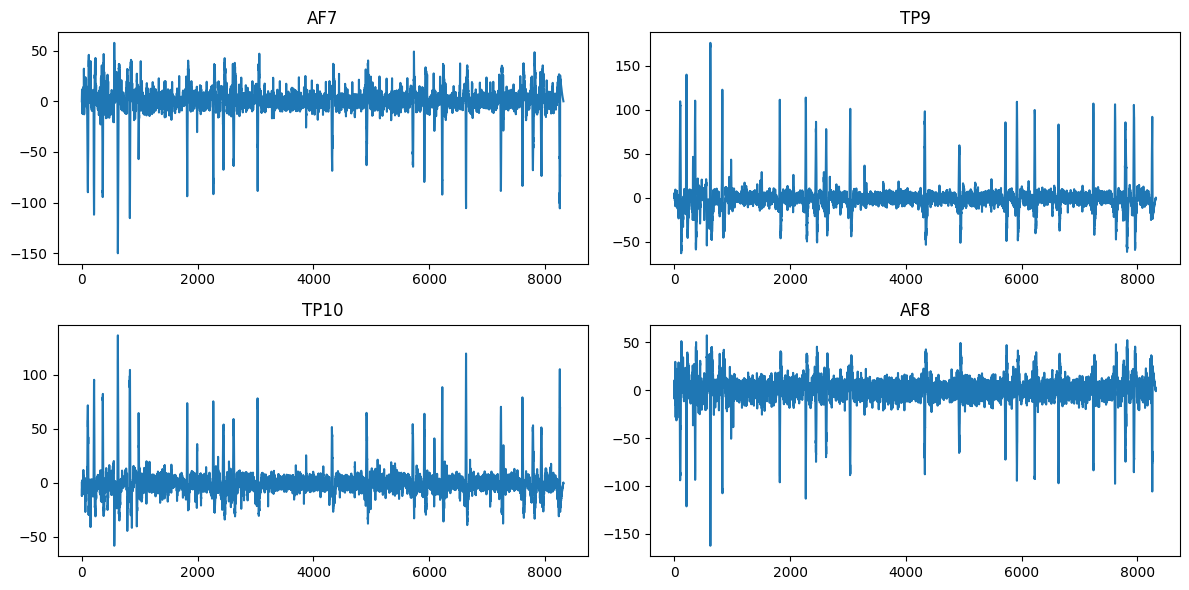

In [4]:
data = raw.get_data(units="uV")
electrodes = raw.ch_names

plt.figure(figsize=(12, 6))
for i, electrode in enumerate(electrodes):
    plt.subplot(2, 2, i + 1)
    plt.plot(data[i])
    plt.title(electrode)
plt.tight_layout()
plt.show()

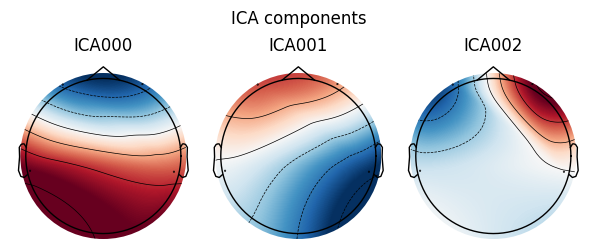

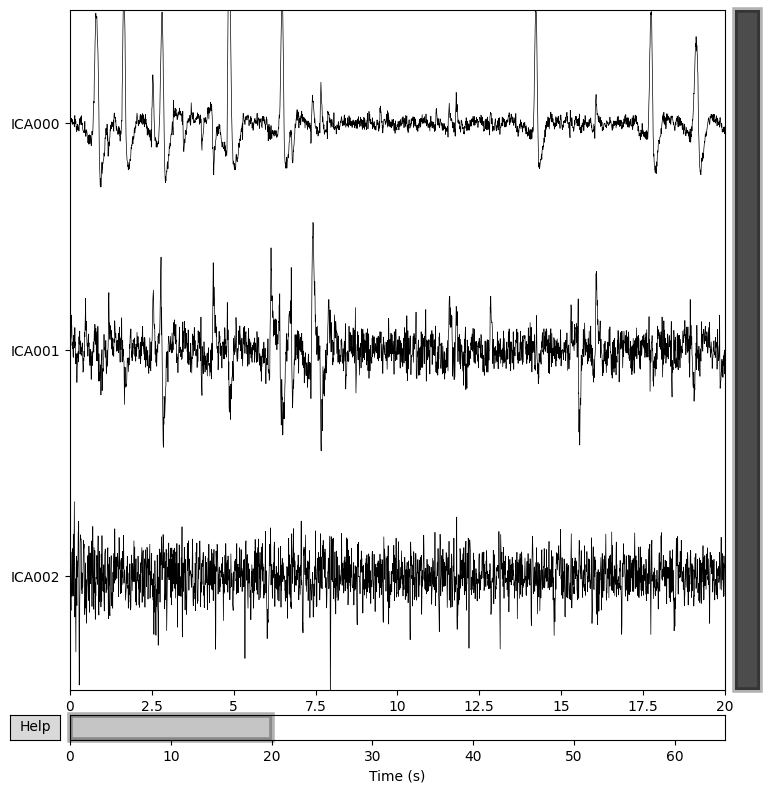

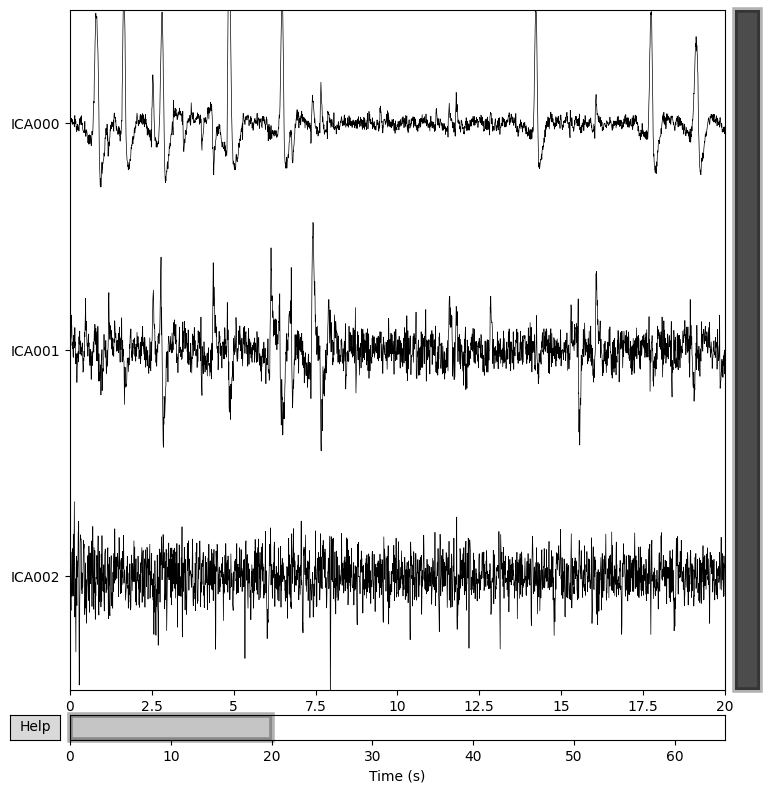

In [11]:
ica = mne.preprocessing.ICA(
    method="picard",
    fit_params={"extended": True, "ortho": False},
    random_state=1
)

ica.fit(raw)

ica.plot_components(inst=raw, picks=range(3))
ica.plot_sources(inst=raw)

In [5]:
import keras 
model = keras.models.load_model("EmotionNetV2.keras")

# split data in 10 sec chunks
chunk_size = 1344 # 10 seconds at 128 Hz
data_chunks = [data[:, i:i + chunk_size] for i in range(0, data.shape[1], chunk_size)]
# add None on first dimension
data_chunks = [np.expand_dims(chunk, axis=0) for chunk in data_chunks]
# model.predict(np.array(data_chunks[0]))

/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 16 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=8320
    Range : 0 ... 8319 =      0.000 ...    64.992 secs
Ready.
Added the following bipolar channels:
EOG
Using EOG channel: EOG
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1280 samples (10.000 s)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann win

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


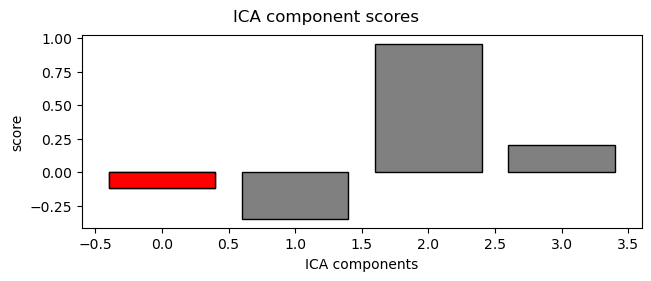

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 1 ICA component
    Projecting back using 4 PCA components


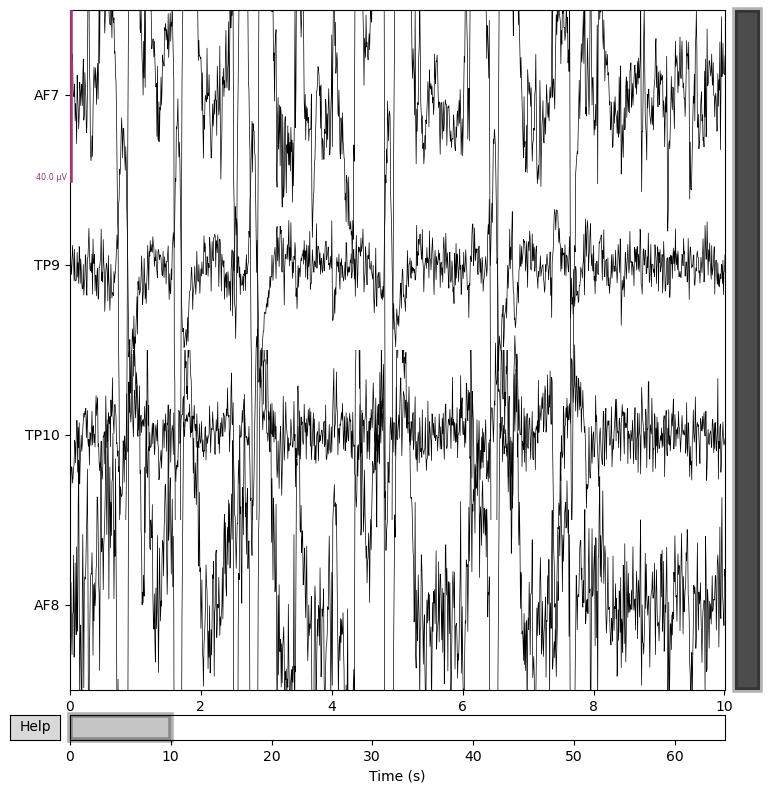

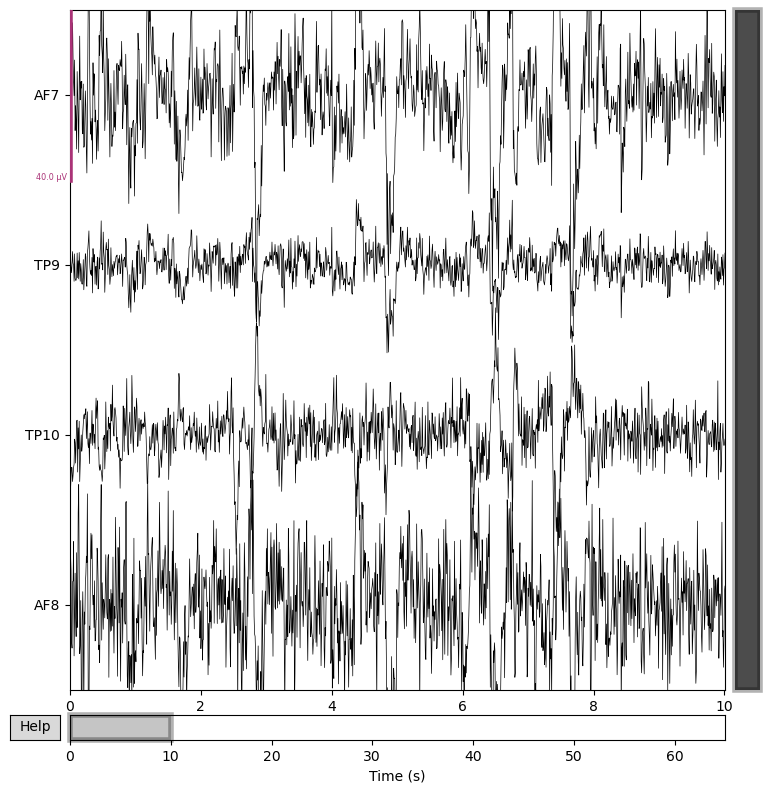

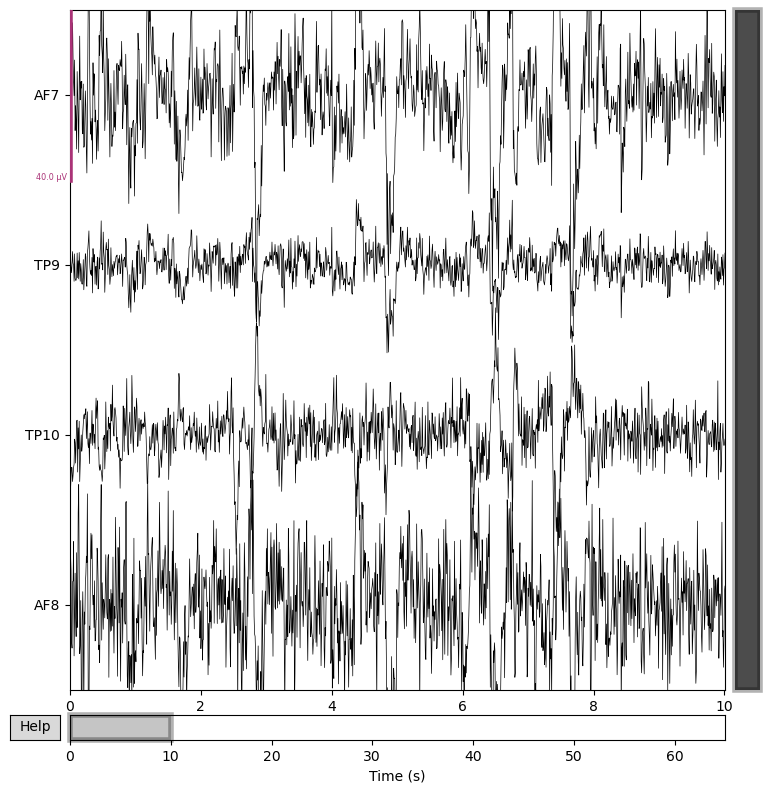

In [35]:
ica.exclude = []
# find which ICs match the EOG pattern
raw_ref = mne.set_bipolar_reference(
    raw,
    ["AF7"],
    ["AF8"],
    ch_name=["EOG"],
    drop_refs=False
)

eog_indices, eog_scores = ica.find_bads_eog(raw_ref, ch_name='EOG', threshold="auto")
print(eog_indices, eog_scores)
ica.exclude = [0]

# barplot of ICA component "EOG match" scores
ica.plot_scores(eog_scores)
raw_corrected = raw.copy()
ica.apply(raw_corrected)

raw.plot(n_channels=4, title="Before")
raw_corrected.plot(n_channels=4, title="After")

In [12]:
data = raw_corrected.get_data(units="uV")
electrodes = raw_corrected.ch_names

plt.figure(figsize=(12, 6))
for i, electrode in enumerate(electrodes):
    plt.subplot(2, 2, i + 1)
    plt.plot(data[i])
    plt.title(electrode)
plt.tight_layout()
plt.show()

NameError: name 'raw_corrected' is not defined

In [13]:
averaged, data = mne.set_eeg_reference(raw_corrected, ref_channels='average', copy=True)

data = averaged.get_data(units="uV")
electrodes = averaged.ch_names

plt.figure(figsize=(12, 6))
for i, electrode in enumerate(electrodes):
    plt.subplot(2, 2, i + 1)
    plt.plot(data[i])
    plt.title(electrode)
plt.tight_layout()
plt.show()

NameError: name 'raw_corrected' is not defined

In [14]:
def read_edf_and_preprocess(file_path, **kwargs):
    raw = mne.io.read_raw_edf(file_path, preload=True)
    raw.resample(128)
    raw.filter(l_freq=1., h_freq=45.)
    raw, _ = mne.set_eeg_reference(raw, ref_channels='average', copy=True)
    epochs = mne.make_fixed_length_epochs(raw, duration=5)
    return epochs

muse_dataset = CSVFolderDataset(
    io_path="./temp/muse/data",
    csv_path="./output.csv",
    read_fn=read_edf_and_preprocess,
    offline_transform=transforms.Compose(
        [
            transforms.BaselineRemoval(),
            # transforms.RandomNoise(0.1),
            transforms.Concatenate(
                [
                    transforms.BandDifferentialEntropy(
                        sampling_rate=128
                    ),
                    transforms.BandPowerSpectralDensity(
                        sampling_rate=128
                    ),
                    transforms.BandHjorth(
                        sampling_rate=128
                    ),
                    transforms.BandSVDEntropy(
                        sampling_rate=128
                    ),
                    transforms.BandKurtosis(
                        sampling_rate=128
                    ),
                ]
            ),
            # transforms.ToGrid(channel_location_dict),
            # transforms.BaselineRemoval(),
            # transforms.MeanStdNormalize(),
            # transforms.To2d()
        ]
    ),
    online_transform=transforms.ToTensor(),
    label_transform=transforms.Compose(
        [
            transforms.Select("label"),
            transforms.Binary(5.0),
        ]
    ),
    after_subject=after_hook_normalize,
    chunk_size=128,
    baseline_chunk_size=3 * 128,
    num_worker=8,
)

[2025-08-29 19:58:36] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ./temp/muse/data.


In [21]:
import numpy as np

sample = np.array(muse_dataset[0][0])
sample.shape

(4, 20)

In [22]:
from torcheeg.model_selection import KFoldGroupbyTrial

k_fold = KFoldGroupbyTrial(n_splits=3,
                           split_path='./temp/muse/split')

In [25]:
from torch.utils.data import DataLoader
from torcheeg.models import CCNN, DGCNN
from torcheeg.trainers import ClassifierTrainer
import torch
import pytorch_lightning as pl

for i, (train_dataset, val_dataset) in enumerate(k_fold.split(muse_dataset)):
    print(f'Fold {i}:')
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    model = DGCNN(in_channels=20,
                  num_electrodes=4,
                  hid_channels=64,
                  num_classes=2)

    trainer = ClassifierTrainer(model=model,
                                num_classes=2,
                                lr=1e-4,
                                weight_decay=1e-4,
                                accelerator="gpu")

    trainer.fit(
        train_loader,
        val_loader,
        max_epochs=50,
        default_root_dir=f"./temp/muse/model/{i}",
        callbacks=[
            pl.callbacks.ModelCheckpoint(save_last=True),
            pl.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, mode="max"),
        ],        enable_progress_bar=True,
        enable_model_summary=True,
        limit_val_batches=0.25,
    )
    
    score = trainer.test(
        val_loader,
        enable_progress_bar=True,
        enable_model_summary=True,
    )[0]
    print(f'Fold {i} test accuracy: {score["test_accuracy"]:.4f}')
    

[2025-08-29 20:16:28] INFO (torcheeg/MainThread) 📊 | Detected existing split of train and test set, use existing split from ./temp/muse/split.
[2025-08-29 20:16:28] INFO (torcheeg/MainThread) 💡 | If the dataset is re-generated, you need to re-generate the split of the dataset instead of using the previous split.


Error: ./temp/muse/data/_record_0/eeg: Too many open files

In [ ]:
from torcheeg.model_selection import train_test_split_cross_subject
from torch.utils.data import DataLoader
from torcheeg.models import CCNN, DGCNN
from torcheeg.trainers import ClassifierTrainer
import torch
import pytorch_lightning as pl

train_dataset, test_dataset = train_test_split_cross_subject(dataset=muse_dataset, test_size=0.2, random_state=42, split_path='./temp/muse/split')
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
model = DGCNN(in_channels=20,
                num_electrodes=4,
                hid_channels=64,
                num_classes=2)

trainer = ClassifierTrainer(model=model,
                            num_classes=2,
                            lr=1e-4,
                            weight_decay=1e-4,
                            accelerator="gpu")

trainer.fit(
    train_loader,
    val_loader,
    max_epochs=50,
    default_root_dir=f"./temp/muse/model",
    callbacks=[
        pl.callbacks.ModelCheckpoint(save_last=True),
        pl.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, mode="max"),
    ],        enable_progress_bar=True,
    enable_model_summary=True,
    limit_val_batches=0.25,
)

score = trainer.test(
    val_loader,
    enable_progress_bar=True,
    enable_model_summary=True,
)[0]

[2025-08-24 12:12:50] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2025-08-24 12:12:50] INFO (torcheeg/MainThread) 😊 | Please set split_path to ./temp/muse/split for the next run, if you want to use the same setting for the experiment.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | DGCNN            | 19.2 K | train
1 | ce_fn         | CrossEntropyLoss | 0      | train
2 | train_loss    | MeanMetric       | 0      | train
3 | val_loss      | MeanMetric       | 0      | train
4 | test_loss     | MeanMetric       | 0      | train
5 | train_metrics | MetricCollection | 0      | train
6 | val_metrics   | MetricCollection | 0      | train
7 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
19.2 K    Train

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.80it/s]

[2025-08-24 12:12:53] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.549 val_accuracy: 0.969 


/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 2153/2153 [00:20<00:00, 107.48it/s, v_num=1, train_loss=0.710, train_accuracy=0.583]

[2025-08-24 12:13:13] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.653 val_accuracy: 0.624 


Epoch 0: 100%|██████████| 2153/2153 [00:20<00:00, 105.64it/s, v_num=1, train_loss=0.710, train_accuracy=0.583]

[2025-08-24 12:13:13] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.692 train_accuracy: 0.556 


Epoch 1: 100%|██████████| 2153/2153 [00:18<00:00, 115.09it/s, v_num=1, train_loss=0.657, train_accuracy=0.583]

[2025-08-24 12:13:32] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.638 val_accuracy: 0.658 


Epoch 1: 100%|██████████| 2153/2153 [00:19<00:00, 112.88it/s, v_num=1, train_loss=0.657, train_accuracy=0.583]

[2025-08-24 12:13:32] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.670 train_accuracy: 0.587 


Epoch 2: 100%|██████████| 2153/2153 [00:19<00:00, 110.78it/s, v_num=1, train_loss=0.601, train_accuracy=0.667]

[2025-08-24 12:13:52] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.636 val_accuracy: 0.647 


Epoch 2: 100%|██████████| 2153/2153 [00:19<00:00, 108.79it/s, v_num=1, train_loss=0.601, train_accuracy=0.667]

[2025-08-24 12:13:52] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.664 train_accuracy: 0.598 


Epoch 3: 100%|██████████| 2153/2153 [00:18<00:00, 115.45it/s, v_num=1, train_loss=0.680, train_accuracy=0.583]

[2025-08-24 12:14:11] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.640 val_accuracy: 0.647 


Epoch 3: 100%|██████████| 2153/2153 [00:19<00:00, 113.29it/s, v_num=1, train_loss=0.680, train_accuracy=0.583]

[2025-08-24 12:14:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.661 train_accuracy: 0.604 


Epoch 4: 100%|██████████| 2153/2153 [00:19<00:00, 112.20it/s, v_num=1, train_loss=0.724, train_accuracy=0.500]

[2025-08-24 12:14:31] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.629 val_accuracy: 0.665 


Epoch 4: 100%|██████████| 2153/2153 [00:19<00:00, 110.11it/s, v_num=1, train_loss=0.724, train_accuracy=0.500]

[2025-08-24 12:14:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.658 train_accuracy: 0.605 


Epoch 5: 100%|██████████| 2153/2153 [00:19<00:00, 109.67it/s, v_num=1, train_loss=0.605, train_accuracy=0.667]

[2025-08-24 12:14:51] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.639 val_accuracy: 0.647 


Epoch 5: 100%|██████████| 2153/2153 [00:20<00:00, 107.16it/s, v_num=1, train_loss=0.605, train_accuracy=0.667]

[2025-08-24 12:14:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.655 train_accuracy: 0.612 


Epoch 6: 100%|██████████| 2153/2153 [00:18<00:00, 115.59it/s, v_num=1, train_loss=0.686, train_accuracy=0.500]

[2025-08-24 12:15:10] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.638 val_accuracy: 0.650 


Epoch 6: 100%|██████████| 2153/2153 [00:18<00:00, 113.43it/s, v_num=1, train_loss=0.686, train_accuracy=0.500]

[2025-08-24 12:15:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.652 train_accuracy: 0.615 


Epoch 7: 100%|██████████| 2153/2153 [00:20<00:00, 105.19it/s, v_num=1, train_loss=0.747, train_accuracy=0.500]

[2025-08-24 12:15:31] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.637 val_accuracy: 0.651 


Epoch 7: 100%|██████████| 2153/2153 [00:20<00:00, 103.31it/s, v_num=1, train_loss=0.747, train_accuracy=0.500]

[2025-08-24 12:15:31] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.650 train_accuracy: 0.617 


Epoch 8: 100%|██████████| 2153/2153 [00:18<00:00, 115.98it/s, v_num=1, train_loss=0.660, train_accuracy=0.667]

[2025-08-24 12:15:50] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.634 val_accuracy: 0.648 


Epoch 8: 100%|██████████| 2153/2153 [00:18<00:00, 113.84it/s, v_num=1, train_loss=0.660, train_accuracy=0.667]

[2025-08-24 12:15:50] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.648 train_accuracy: 0.620 


Epoch 9: 100%|██████████| 2153/2153 [00:19<00:00, 108.45it/s, v_num=1, train_loss=0.660, train_accuracy=0.667]

[2025-08-24 12:16:10] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.638 val_accuracy: 0.639 


Epoch 9: 100%|██████████| 2153/2153 [00:20<00:00, 106.44it/s, v_num=1, train_loss=0.660, train_accuracy=0.667]

[2025-08-24 12:16:10] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.646 train_accuracy: 0.622 


Epoch 10: 100%|██████████| 2153/2153 [00:19<00:00, 108.43it/s, v_num=1, train_loss=0.547, train_accuracy=0.750]

[2025-08-24 12:16:30] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.624 val_accuracy: 0.652 


Epoch 10: 100%|██████████| 2153/2153 [00:20<00:00, 106.18it/s, v_num=1, train_loss=0.547, train_accuracy=0.750]

[2025-08-24 12:16:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.645 train_accuracy: 0.624 


Epoch 11: 100%|██████████| 2153/2153 [00:20<00:00, 105.90it/s, v_num=1, train_loss=0.624, train_accuracy=0.583]

[2025-08-24 12:16:51] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.629 val_accuracy: 0.648 


Epoch 11: 100%|██████████| 2153/2153 [00:20<00:00, 104.08it/s, v_num=1, train_loss=0.624, train_accuracy=0.583]

[2025-08-24 12:16:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.642 train_accuracy: 0.624 


Epoch 12: 100%|██████████| 2153/2153 [00:18<00:00, 113.40it/s, v_num=1, train_loss=0.598, train_accuracy=0.583]

[2025-08-24 12:17:11] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.634 val_accuracy: 0.648 


Epoch 12: 100%|██████████| 2153/2153 [00:19<00:00, 111.32it/s, v_num=1, train_loss=0.598, train_accuracy=0.583]

[2025-08-24 12:17:11] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.641 train_accuracy: 0.628 


Epoch 13: 100%|██████████| 2153/2153 [00:18<00:00, 113.77it/s, v_num=1, train_loss=0.653, train_accuracy=0.667]

[2025-08-24 12:17:30] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.627 val_accuracy: 0.657 


Epoch 13: 100%|██████████| 2153/2153 [00:19<00:00, 111.43it/s, v_num=1, train_loss=0.653, train_accuracy=0.667]

[2025-08-24 12:17:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.639 train_accuracy: 0.629 


Epoch 14: 100%|██████████| 2153/2153 [00:20<00:00, 103.61it/s, v_num=1, train_loss=0.652, train_accuracy=0.583]

[2025-08-24 12:17:51] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.642 val_accuracy: 0.643 


Epoch 14: 100%|██████████| 2153/2153 [00:21<00:00, 101.88it/s, v_num=1, train_loss=0.652, train_accuracy=0.583]

[2025-08-24 12:17:51] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.637 train_accuracy: 0.631 


Epoch 14: 100%|██████████| 2153/2153 [00:21<00:00, 101.61it/s, v_num=1, train_loss=0.652, train_accuracy=0.583]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 241/241 [00:01<00:00, 195.31it/s]

[2025-08-24 12:17:52] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.688 test_accuracy: 0.577 


Testing DataLoader 0: 100%|██████████| 241/241 [00:01<00:00, 194.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5765929818153381     │
│         test_loss         │    0.6876118183135986     │
└───────────────────────────┴───────────────────────────┘

In [51]:
# loader = DataLoader(dataset, batch_size=64, shuffle=True)
# loader = DataLoader(muse_dataset, batch_size=64, shuffle=True)
from torcheeg.model_selection import train_test_split

train_dataset, test_dataset = train_test_split(dataset=muse_dataset)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model = CCNN(num_classes=2, in_channels=8, grid_size=(5, 9))
model.load_state_dict(torch.load("./models/deap_model.pth"))

for conv in [model.conv1, model.conv2, model.conv3, model.conv4]:
    for param in conv.parameters():
        param.requires_grad = False

for param in model.conv4.parameters():
    param.requires_grad = True

trainer = ClassifierTrainer(
    model=model, num_classes=2, lr=1e-4, weight_decay=1e-4, accelerator="gpu"
)

trainer.fit(
    train_loader,
    test_loader,
    max_epochs=10,
    default_root_dir="./temp/deap/model",
    callbacks=[
        pl.callbacks.ModelCheckpoint(save_last=True),
        pl.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, mode="max"),
    ],
    enable_progress_bar=True,
    enable_model_summary=True,
    limit_val_batches=0.5,
)

score = trainer.test(
    test_loader,
    enable_progress_bar=True,
    enable_model_summary=True,
)[0]
print(f'test accuracy: {score["test_accuracy"]:.4f}')

[2025-08-17 04:48:51] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2025-08-17 04:48:51] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1755395331085_lSi9j for the next run, if you want to use the same setting for the experiment.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | CCNN             | 3.9 M  | train
1 | ce_fn         | CrossEntropyLoss | 0      | train
2 | train_loss    | MeanMetric       | 0      | train
3 | val_loss      | MeanMetric       | 0      | train
4 | test_loss     | MeanMetric       | 0      | train
5 | train_metrics | MetricCollection | 0      | train
6 | val_metrics   | MetricCollection | 0      | train
7 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 45.08it/s]

[2025-08-17 04:48:54] INFO (torcheeg/MainThread) 
[Val] val_loss: 1.459 val_accuracy: 0.000 


/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 958/958 [00:23<00:00, 40.62it/s, v_num=7, train_loss=0.694, train_accuracy=0.250]

[2025-08-17 04:49:20] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.694 val_accuracy: 0.497 


Epoch 0: 100%|██████████| 958/958 [00:25<00:00, 37.98it/s, v_num=7, train_loss=0.694, train_accuracy=0.250]

[2025-08-17 04:49:20] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.708 train_accuracy: 0.502 


Epoch 1: 100%|██████████| 958/958 [00:19<00:00, 49.11it/s, v_num=7, train_loss=0.686, train_accuracy=0.750]

[2025-08-17 04:49:41] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.693 val_accuracy: 0.506 


Epoch 1: 100%|██████████| 958/958 [00:20<00:00, 46.06it/s, v_num=7, train_loss=0.686, train_accuracy=0.750]

[2025-08-17 04:49:41] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.518 


Epoch 2: 100%|██████████| 958/958 [00:19<00:00, 49.29it/s, v_num=7, train_loss=0.645, train_accuracy=1.000]

[2025-08-17 04:50:02] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.693 val_accuracy: 0.507 


Epoch 2: 100%|██████████| 958/958 [00:20<00:00, 46.17it/s, v_num=7, train_loss=0.645, train_accuracy=1.000]

[2025-08-17 04:50:02] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.692 train_accuracy: 0.524 


Epoch 3: 100%|██████████| 958/958 [00:19<00:00, 49.33it/s, v_num=7, train_loss=0.667, train_accuracy=0.500]

[2025-08-17 04:50:24] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.692 val_accuracy: 0.509 


Epoch 3: 100%|██████████| 958/958 [00:21<00:00, 45.57it/s, v_num=7, train_loss=0.667, train_accuracy=0.500]

[2025-08-17 04:50:24] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.691 train_accuracy: 0.528 


Epoch 4: 100%|██████████| 958/958 [00:20<00:00, 47.62it/s, v_num=7, train_loss=0.671, train_accuracy=0.750]

[2025-08-17 04:50:46] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.693 val_accuracy: 0.508 


Epoch 4: 100%|██████████| 958/958 [00:21<00:00, 44.71it/s, v_num=7, train_loss=0.671, train_accuracy=0.750]

[2025-08-17 04:50:46] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.691 train_accuracy: 0.528 


Epoch 5: 100%|██████████| 958/958 [00:19<00:00, 48.07it/s, v_num=7, train_loss=0.758, train_accuracy=0.000]

[2025-08-17 04:51:08] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.692 val_accuracy: 0.514 


Epoch 5: 100%|██████████| 958/958 [00:21<00:00, 44.15it/s, v_num=7, train_loss=0.758, train_accuracy=0.000]

[2025-08-17 04:51:08] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.691 train_accuracy: 0.529 


Epoch 6: 100%|██████████| 958/958 [00:19<00:00, 47.93it/s, v_num=7, train_loss=0.703, train_accuracy=0.500]

[2025-08-17 04:51:30] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.693 val_accuracy: 0.508 


Epoch 6: 100%|██████████| 958/958 [00:21<00:00, 44.37it/s, v_num=7, train_loss=0.703, train_accuracy=0.500]

[2025-08-17 04:51:30] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.691 train_accuracy: 0.532 


Epoch 7: 100%|██████████| 958/958 [00:28<00:00, 33.27it/s, v_num=7, train_loss=0.703, train_accuracy=0.250]

[2025-08-17 04:52:00] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.691 val_accuracy: 0.517 


Epoch 7: 100%|██████████| 958/958 [00:30<00:00, 31.70it/s, v_num=7, train_loss=0.703, train_accuracy=0.250]

[2025-08-17 04:52:00] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.691 train_accuracy: 0.532 


Epoch 8:  37%|███▋      | 354/958 [00:07<00:12, 49.70it/s, v_num=7, train_loss=0.690, train_accuracy=0.641]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/Users/andrei/miniforge3/envs/tf/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3678: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
